# Exercise - VaR

## Data

This problem uses `weekly` return data from `data/spx_returns_weekly.xlsx`.

Choose any `4` stocks to evaluate below.

For example, 
* `AAPL`
* `META`
* `NVDA`
* `TSLA`

# Section 1: Diversification

## 1.1

Using the full sample, calculate for each series the (unconditional) 

(a) volatility

(b) empirical VaR (.05)

(c) empirical CVaR (.05)

Recall that by **empirical** we refer to the direct quantile estimation. (For example, using `.quantile()` in pandas.

In [11]:
# Question 1.1 Code Here

import pandas as pd
import numpy as np

# Load Data
df = pd.read_excel("../data/spx_returns_weekly.xlsx", sheet_name="s&p500 rets", index_col="date")

#1.1
#Freq = 52 # No need to annualized?
Ticker = ["AAPL","META", "NVDA","TSLA"]
data = df[Ticker].copy()

vol = data.std() 
VaR = data.quantile(0.05)
cVaR_dic = {}
for tick in Ticker:
    sub_df = data[tick].copy()
    var = sub_df.quantile(0.05)
    cVaR_dic[tick] = sub_df[sub_df.le(var)].mean()

cVaR = pd.Series(cVaR_dic)

Risk_Table = pd.concat([vol, VaR, cVaR], axis= 1, keys=['vol', 'VaR', 'cVaR'])
Risk_Table


,vol,VaR,cVaR
AAPL,0.038362,-0.056366,-0.083125
META,0.048722,-0.070012,-0.103196
NVDA,0.064246,-0.086853,-0.116455
TSLA,0.081323,-0.117397,-0.147814


-----

## 1.2
(a) Form an equally-weighted portfolio of the investments.

In [12]:
# Question 1.2 Code Here
data["eq"] = (data["AAPL"]+ data["META"]+ data["NVDA"]+ data["TSLA"])/4

vol = data.std()
VaR = data.quantile(0.05)
cVaR_dic = {}
Ticker.append('eq')
for tick in Ticker:
    sub_df = data[tick].copy()
    var = sub_df.quantile(0.05)
    cVaR_dic[tick] = sub_df[sub_df.le(var)].mean()

cVaR = pd.Series(cVaR_dic)

Risk_Table_2 = pd.concat([vol, VaR, cVaR], axis= 1, keys=['vol', 'VaR', 'cVaR'])
Risk_Table_2


,vol,VaR,cVaR
AAPL,0.038362,-0.056366,-0.083125
META,0.048722,-0.070012,-0.103196
NVDA,0.064246,-0.086853,-0.116455
TSLA,0.081323,-0.117397,-0.147814
eq,0.043758,-0.061950,-0.084992


(b) Calculate the statistics of `1.1` for this portfolio, and compare the results to the individual return statistics. 

(c) What do you find? What is driving this result?

The equal-weighted portfolio has vol, VaR, cVaR that is smaller than simply take average of the four stocks' matric. This is because there is correlation smaller than 1 amound these 4 stock.

-----

## 1.3
(a) Re-calculate `1.2`, but this time drop your most volatile asset, and replace the portion it was getting with 0. 

You could imagine we're replacing the most volatile asset with a negligibly small risk-free rate.

(b) In comparing the answer here to 1.2, how much risk is your most volatile asset adding to the portfolio? 

In [13]:
# Question 1.3 Part (a) Code Here
data["new"] = (data["AAPL"]+ data["META"]+ data["NVDA"]) /4

vol = data.std()
VaR = data.quantile(0.05)
cVaR_dic = {}
Ticker.append('new')
for tick in Ticker:
    sub_df = data[tick].copy()
    var = sub_df.quantile(0.05)
    cVaR_dic[tick] = sub_df[sub_df.le(var)].mean()

cVaR = pd.Series(cVaR_dic)

Risk_Table_3 = pd.concat([vol, VaR, cVaR], axis= 1, keys=['vol', 'VaR', 'cVaR'])
Risk_Table_3

,vol,VaR,cVaR
AAPL,0.038362,-0.056366,-0.083125
META,0.048722,-0.070012,-0.103196
NVDA,0.064246,-0.086853,-0.116455
TSLA,0.081323,-0.117397,-0.147814
eq,0.043758,-0.061950,-0.084992
new,0.030282,-0.042463,-0.060531


(c) In comparing the answer here to 1.2, how much risk is your most volatile asset adding to the portfolio? Is this in line with the amount of risk we measured in the stand-alone risk-assessment of `1.1`?

The vol, VaR, and cVaR down 1/3 ~1/4, but less than 1/4 of the the stand-alone risk of the TSLA. This is because the risk TSLA add to the portfolio, is its correlation with the whole portfolio, which is smaller than its stand-alone risk.

-----

# Section 2: Dynamic Measures

## 2.1 

Let's measure the **conditional** statistics of the equally-weighted portfolio of `1.2`, as of the end of the sample.

Note:
- Suppose we can approximate that the daily mean return is zero.
- In this setup, we are using a forecasted volatility, $\sigma_t$ to estimate the VaR return we would have estimated at the end of $t-1$ in prediction of time $t$.

(a) Volatility

For each security, calculate the **rolling** volatility series, $\sigma_t$, with a window of $m=26$.

The value at $\sigma_t$ in the notes denotes the estimate using data through time $t-1$, and thus (potentially) predicting the volatility at $\sigma_{t}$. 

(b) VaR

Calculate the **normal VaR** and **normal CVaR** for $q=.05$ and $\tau=1$ as of the end of the sample.Use the approximation, $\texttt{z}_{.05} = -1.65$.

(c) Conclude and Compare
Report
* volatility (annualized).
* normal VaR (.05)
* normal CVaR (.05)

How do these compare to the answers in `1.2`?

In [14]:
# Question 2.1 Code Here

from scipy.stats import norm

data_big = data.copy()
data_big.reset_index(inplace= True)

vol = {}
Var = {}
cVar = {}
vol_annualized = {}
for tick in Ticker:
    data_big[tick+'_Sigma'] = np.nan
    data_big[tick+'_VaR'] = np.nan
    data_big[tick+'_cVaR'] = np.nan

    for i in range(26, len(data)):
        data_big.loc[i, tick+'_Sigma'] = data_big[tick][i-26: i].std() 
        data_big.loc[i, tick+'_VaR'] = -1.65 * data_big[tick+'_Sigma'][i]
        data_big.loc[i, tick+'_cVaR'] = -1* data_big[tick+'_Sigma'][i] * norm.pdf(-1.65) / 0.05
    
    vol[tick] = data_big[tick+'_Sigma'].iloc[-1]
    Var[tick] = data_big[tick+'_VaR'].iloc[-1]
    cVar[tick] = data_big[tick+'_cVaR'].iloc[-1]
    vol_annualized[tick] = data_big[tick+'_Sigma'].iloc[-1] * np.sqrt(52)



vol = pd.Series(vol)
Var = pd.Series(Var)
cVar = pd.Series(cVar)
vol_annualized = pd.Series(vol_annualized)

Risk_Table_4 = pd.concat([vol, Var, cVar, vol_annualized], axis= 1, keys=['vol_c', 'VaR_c', 'cVaR_C', 'vol_ann'])

Risk_Table_4, Risk_Table_2


(         vol_c     VaR_c    cVaR_C   vol_ann
 AAPL  0.049628 -0.081886 -0.101504  0.357871
 META  0.057751 -0.095290 -0.118119  0.416450
 NVDA  0.082727 -0.136499 -0.169201  0.596552
 TSLA  0.084876 -0.140046 -0.173598  0.612053
 eq    0.053749 -0.088686 -0.109933  0.387590
 new   0.038313 -0.063217 -0.078362  0.276281,
            vol       VaR      cVaR
 AAPL  0.038362 -0.056366 -0.083125
 META  0.048722 -0.070012 -0.103196
 NVDA  0.064246 -0.086853 -0.116455
 TSLA  0.081323 -0.117397 -0.147814
 eq    0.043758 -0.061950 -0.084992)

Q: How do these compare to the answers in 1.2?

A: The conditional statistics and the empirical statistics shows significant different in their risk metrics.

-----

## 2.2

Backtest the VaR using the **hit test**. 

Namely, check how many times the realized return at $t$ was smaller than the VaR return calculated using $\sigma_t$, (where again remember the notation in the notes uses $\sigma_t$ as a vol based on data through $t-1$.)

Report the percentage of "hits" using both the

(a) expanding volatility

(b) rolling volatility

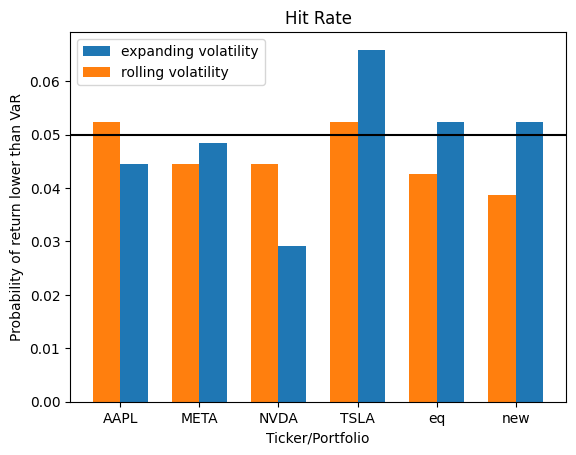

In [15]:
# Question 2.2 code here

import matplotlib.pyplot as plt

def hit_test_rolling(data, tick, term = 26):
    new_df = data.copy()
    new_df['Sigma'] = np.nan
    new_df['VaR'] = np.nan

    new_df.reset_index(inplace= True)

    hit = 0
    for i in range(term, len(new_df)):
        new_df.loc[i, 'Sigma'] = new_df[tick][i-term: i].std()
        new_df.loc[i, 'VaR'] = -1.65 * new_df['Sigma'][i]
        if new_df[tick][i] < new_df['VaR'][i]:
            hit += 1
    
    return hit/ (len(new_df)-term)

def hit_test_expanding(data, tick, term = 26):
    new_df = data.copy()
    new_df['Sigma'] = np.nan
    new_df['VaR'] = np.nan

    new_df.reset_index(inplace= True)

    hit = 0
    for i in range(term, len(new_df)):
        new_df.loc[i, 'Sigma'] = new_df[tick][0: i].std()
        new_df.loc[i, 'VaR'] = -1.65 * new_df['Sigma'][i]
        if new_df[tick][i] < new_df['VaR'][i]:
            hit += 1
    
    return hit/ (len(new_df)-term)


rolling_list = []
expanding_list = []
for tick in Ticker:
    rolling_list.append(hit_test_rolling(data, tick))
    expanding_list.append(hit_test_expanding(data, tick))

x = np.arange(len(Ticker)) 
width = 0.35                  
plt.bar(x + width/2, expanding_list, width, label='expanding volatility')     
plt.bar(x - width/2, rolling_list, width, label='rolling volatility')


# 標籤與標題
plt.xticks(x, Ticker)
plt.xlabel('Ticker/Portfolio')
plt.ylabel('Probability of return lower than VaR')
plt.title('Hit Rate')
plt.legend()

plt.axhline(y=0.05, color='black', linestyle='-')

plt.show()
